In [40]:
#libraries
import tensorflow
import numpy as np
from tensorflow.keras.utils import to_categorical
import keras
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report as cr 
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier as knc
from sklearn import metrics
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

In [20]:
column_names = [
  'user_id',
  'activity',
  'timestamp',
  'x_axis',
  'y_axis',
  'z_axis'
]

df = pd.read_csv(
  'WISDM_ar_v1.1_raw.txt',
  header=None,
  names=column_names,
    on_bad_lines='skip'
)

df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)
df.shape

(1086465, 6)

In [21]:
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1086461,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1086462,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1086463,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1086464,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [43]:
df['activity'].value_counts()

Walking       418393
Jogging       336445
Upstairs      122869
Downstairs    100425
Sitting        59939
Standing       48394
Name: activity, dtype: int64

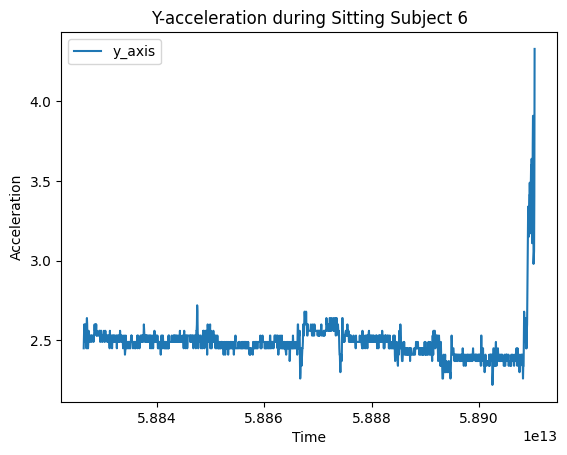

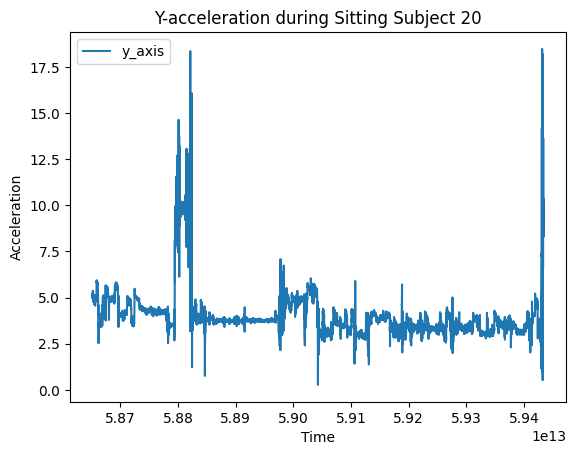

In [28]:
#x axis acceleration for subject_1 in activity 
tmp = df[(df['user_id'] == 6) & (df['activity'].isin(['Sitting']))][['y_axis','timestamp']]
tmp = tmp.melt(id_vars = ['timestamp'], var_name='axis', value_name='acceleration')
tmp = tmp.set_index('timestamp')
tmp.groupby('axis')['acceleration'].plot(legend='True')
plt.title('Y-acceleration during Sitting Subject 6')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.show()

#x axis acceleration for subject_1 in activity 
tmp = df[(df['user_id'] == 20) & (df['activity'].isin(['Sitting']))][['y_axis','timestamp']]
tmp = tmp.melt(id_vars = ['timestamp'], var_name='axis', value_name='acceleration')
tmp = tmp.set_index('timestamp')
tmp.groupby('axis')['acceleration'].plot(legend='True')
plt.title('Y-acceleration during Sitting Subject 20')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.show()

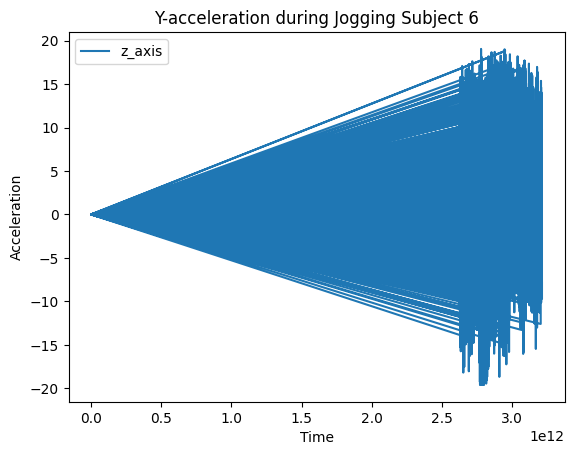

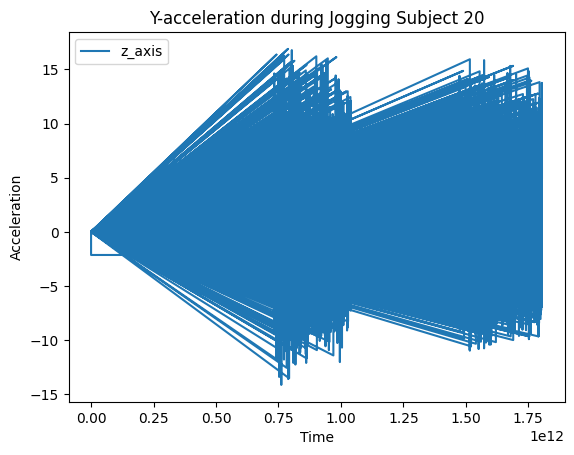

In [29]:
#x axis acceleration for subject_1 in activity 
tmp = df[(df['user_id'] == 6) & (df['activity'].isin(['Jogging']))][['z_axis','timestamp']]
tmp = tmp.melt(id_vars = ['timestamp'], var_name='axis', value_name='acceleration')
tmp = tmp.set_index('timestamp')
tmp.groupby('axis')['acceleration'].plot(legend='True')
plt.title('Y-acceleration during Jogging Subject 6')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.show()

#x axis acceleration for subject_1 in activity 
tmp = df[(df['user_id'] == 20) & (df['activity'].isin(['Jogging']))][['z_axis','timestamp']]
tmp = tmp.melt(id_vars = ['timestamp'], var_name='axis', value_name='acceleration')
tmp = tmp.set_index('timestamp')
tmp.groupby('axis')['acceleration'].plot(legend='True')
plt.title('Y-acceleration during Jogging Subject 20')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.show()

In [30]:
#Bi Directional LSTM

In [31]:
#train test split
df_train = df[df['user_id'] <= 30]
df_test = df[df['user_id'] > 30]



In [34]:
scale_columns = ['x_axis', 'y_axis', 'z_axis']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(
  df_train[scale_columns].to_numpy()
)

df_test.loc[:, scale_columns] = scaler.transform(
  df_test[scale_columns].to_numpy()
)

In [35]:
def create_dataset(X, y, time_steps, step):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [36]:
TIME_STEPS = 128
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']],
    df_train.activity,
    TIME_STEPS,
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']],
    df_test.activity,
    TIME_STEPS,
    STEP
)

In [37]:

print(X_train.shape, y_train.shape)

(22163, 128, 3) (22163, 1)


In [38]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [41]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['acc']
)

In [42]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/20
312/312 [==============================] - 87s 267ms/step - loss: 1.4584 - acc: 0.5053 - val_loss: 1.2097 - val_acc: 0.6464
Epoch 2/20
312/312 [==============================] - 79s 252ms/step - loss: 1.2641 - acc: 0.5524 - val_loss: 1.1510 - val_acc: 0.5968
Epoch 3/20
312/312 [==============================] - 77s 246ms/step - loss: 1.1226 - acc: 0.6285 - val_loss: 1.0494 - val_acc: 0.6432
Epoch 4/20
312/312 [==============================] - 72s 231ms/step - loss: 0.9895 - acc: 0.6792 - val_loss: 0.8236 - val_acc: 0.7664
Epoch 5/20
312/312 [==============================] - 72s 231ms/step - loss: 0.9578 - acc: 0.6695 - val_loss: 1.0186 - val_acc: 0.7194
Epoch 6/20
312/312 [==============================] - 76s 243ms/step - loss: 0.9475 - acc: 0.6796 - val_loss: 0.7792 - val_acc: 0.7659
Epoch 7/20
312/312 [==============================] - 80s 258ms/step - loss: 0.8733 - acc: 0.7101 - val_loss: 0.8116 - val_acc: 0.7682
Epoch 8/20
312/312 [==============================] - 7

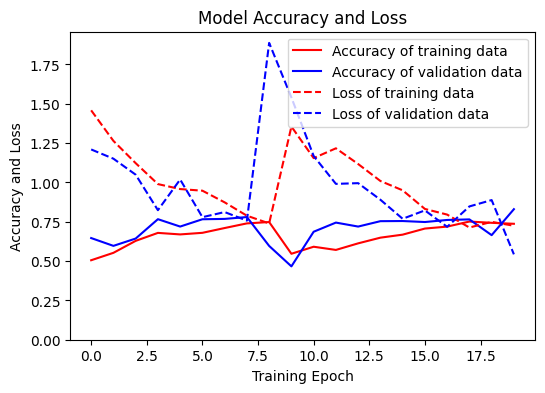

693/693 [==============================] - 39s 54ms/step
              precision    recall  f1-score   support

           0       0.57      0.03      0.06      2067
           1       0.94      0.95      0.95      6741
           2       0.99      0.84      0.91      1144
           3       0.94      0.78      0.85       956
           4       0.52      0.01      0.03      2569
           5       0.64      0.99      0.78      8686

    accuracy                           0.76     22163
   macro avg       0.77      0.60      0.60     22163
weighted avg       0.74      0.76      0.69     22163



In [46]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model.predict(X_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(np.argmax(y_train, axis = 1), max_y_pred_train))

In [62]:
TIME_STEPS = 80
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']],
    df_train.activity,
    TIME_STEPS,
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']],
    df_test.activity,
    TIME_STEPS,
    STEP
)

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['acc']
)

In [63]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=500,
    validation_split=0.1,
    shuffle=False
) 

Epoch 1/20
40/40 [==============================] - 29s 618ms/step - loss: 1.6327 - acc: 0.4388 - val_loss: 1.3046 - val_acc: 0.6143
Epoch 2/20
40/40 [==============================] - 23s 576ms/step - loss: 1.3563 - acc: 0.5163 - val_loss: 1.1808 - val_acc: 0.6401
Epoch 3/20
40/40 [==============================] - 25s 624ms/step - loss: 1.2700 - acc: 0.5212 - val_loss: 1.1649 - val_acc: 0.6243
Epoch 4/20
40/40 [==============================] - 26s 664ms/step - loss: 1.2088 - acc: 0.5746 - val_loss: 1.1204 - val_acc: 0.6441
Epoch 5/20
40/40 [==============================] - 27s 684ms/step - loss: 1.1594 - acc: 0.5759 - val_loss: 1.0865 - val_acc: 0.6951
Epoch 6/20
40/40 [==============================] - 28s 688ms/step - loss: 1.1283 - acc: 0.5911 - val_loss: 1.1166 - val_acc: 0.6793
Epoch 7/20
40/40 [==============================] - 26s 651ms/step - loss: 1.0674 - acc: 0.6295 - val_loss: 1.0315 - val_acc: 0.6820
Epoch 8/20
40/40 [==============================] - 26s 651ms/step - 

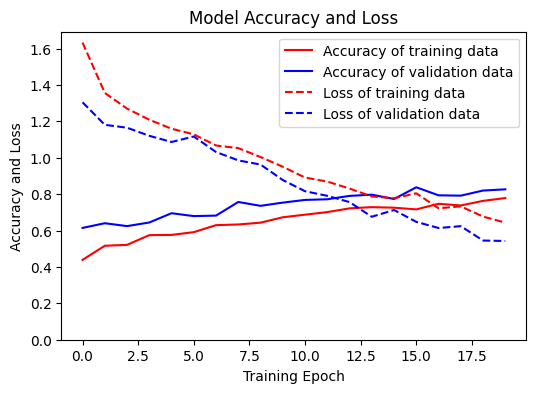

693/693 [==============================] - 19s 26ms/step
              precision    recall  f1-score   support

           0       0.52      0.08      0.14      2064
           1       0.95      0.98      0.96      6742
           2       0.95      0.90      0.92      1146
           3       0.84      0.69      0.76       951
           4       0.48      0.13      0.20      2572
           5       0.70      0.99      0.82      8689

    accuracy                           0.78     22164
   macro avg       0.74      0.63      0.63     22164
weighted avg       0.75      0.78      0.73     22164



In [64]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model.predict(X_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(np.argmax(y_train, axis = 1), max_y_pred_train))

In [65]:
TIME_STEPS = 50
STEP = 30

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']],
    df_train.activity,
    TIME_STEPS,
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']],
    df_test.activity,
    TIME_STEPS,
    STEP
)

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['acc']
)

In [66]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=500,
    validation_split=0.1,
    shuffle=False
) 

Epoch 1/20
54/54 [==============================] - 22s 352ms/step - loss: 1.5891 - acc: 0.4273 - val_loss: 1.3200 - val_acc: 0.5995
Epoch 2/20
54/54 [==============================] - 19s 354ms/step - loss: 1.3789 - acc: 0.5130 - val_loss: 1.2144 - val_acc: 0.5927
Epoch 3/20
54/54 [==============================] - 18s 325ms/step - loss: 1.2922 - acc: 0.5321 - val_loss: 1.1822 - val_acc: 0.6661
Epoch 4/20
54/54 [==============================] - 20s 375ms/step - loss: 1.2269 - acc: 0.5522 - val_loss: 1.1099 - val_acc: 0.7250
Epoch 5/20
54/54 [==============================] - 20s 366ms/step - loss: 1.2046 - acc: 0.5648 - val_loss: 1.0494 - val_acc: 0.7588
Epoch 6/20
54/54 [==============================] - 18s 328ms/step - loss: 1.1103 - acc: 0.6112 - val_loss: 0.9641 - val_acc: 0.7622
Epoch 7/20
54/54 [==============================] - 18s 326ms/step - loss: 1.0723 - acc: 0.6471 - val_loss: 0.9005 - val_acc: 0.7392
Epoch 8/20
54/54 [==============================] - 21s 395ms/step - 

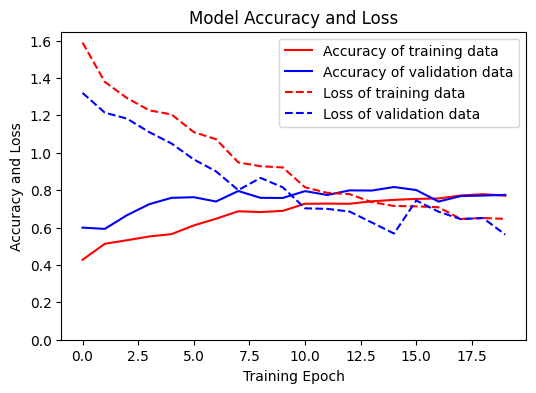

924/924 [==============================] - 15s 15ms/step
              precision    recall  f1-score   support

           0       0.67      0.09      0.15      2755
           1       0.95      0.97      0.96      8991
           2       0.93      0.94      0.93      1524
           3       0.93      0.56      0.70      1273
           4       0.72      0.09      0.16      3429
           5       0.67      1.00      0.80     11581

    accuracy                           0.78     29553
   macro avg       0.81      0.61      0.62     29553
weighted avg       0.78      0.78      0.72     29553



In [67]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model.predict(X_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(np.argmax(y_train, axis = 1), max_y_pred_train))

In [72]:
!pip install gdown

In [73]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [74]:
!gdown --id 152sWECukjvLerrVG2NUO8gtMFg83RKCF --output WISDM_ar_latest.tar.gz
!tar -xvf WISDM_ar_latest.tar.gz

C:\Users\DPS\anaconda3\lib\site-packages\gdown\cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=152sWECukjvLerrVG2NUO8gtMFg83RKCF
To: C:\Users\DPS\Desktop\Syed\AIT582\Activity Recognition from Single Chest-Mounted Accelerometer\Activity Recognition from Single Chest-Mounted Accelerometer\WISDM_ar_v1.1\WISDM_ar_latest.tar.gz

  0%|          | 0.00/11.4M [00:00<?, ?B/s]
 23%|##2       | 2.62M/11.4M [00:00<00:00, 23.9MB/s]
 46%|####5     | 5.24M/11.4M [00:00<00:00, 24.6MB/s]
100%|##########| 11.4M/11.4M [00:00<00:00, 40.2MB/s]
x WISDM_ar_v1.1/
x WISDM_ar_v1.1/readme.txt
x WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt
x WISDM_ar_v1.1/WISDM_ar_v1.1_raw_about.txt
x WISDM_ar_v1.1/WISDM_ar_v1.1_transformed.arff
x WISDM_ar_v1.1/WISDM_ar_v1.1_trans_about.txt


In [76]:
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

df = pd.read_csv('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None, names=column_names, on_bad_lines='skip')
df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)

In [77]:
df.shape

(1086465, 6)

In [78]:
df_train = df[df['user_id'] <= 30]
df_test = df[df['user_id'] > 30]

In [79]:
from sklearn.preprocessing import RobustScaler

scale_columns = ['x_axis', 'y_axis', 'z_axis']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

In [80]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']], 
    df_train.activity, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']], 
    df_test.activity, 
    TIME_STEPS, 
    STEP
)

In [81]:
print(X_train.shape, y_train.shape)

(22161, 200, 3) (22161, 1)


In [82]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [83]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [84]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

Epoch 1/20
312/312 [==============================] - 658s 2s/step - loss: 1.0590 - acc: 0.6307 - val_loss: 1.1561 - val_acc: 0.6419
Epoch 2/20
312/312 [==============================] - 637s 2s/step - loss: 0.6741 - acc: 0.7563 - val_loss: 0.6761 - val_acc: 0.7862
Epoch 3/20
312/312 [==============================] - 637s 2s/step - loss: 0.5847 - acc: 0.7920 - val_loss: 0.6485 - val_acc: 0.8101
Epoch 4/20
312/312 [==============================] - 628s 2s/step - loss: 0.4652 - acc: 0.8431 - val_loss: 0.5926 - val_acc: 0.8146
Epoch 5/20
312/312 [==============================] - 622s 2s/step - loss: 0.4172 - acc: 0.8560 - val_loss: 0.6443 - val_acc: 0.8318
Epoch 6/20
312/312 [==============================] - 633s 2s/step - loss: 0.3894 - acc: 0.8636 - val_loss: 0.5554 - val_acc: 0.8151
Epoch 7/20
312/312 [==============================] - 628s 2s/step - loss: 0.3750 - acc: 0.8697 - val_loss: 0.3954 - val_acc: 0.8606
Epoch 8/20
312/312 [==============================] - 619s 2s/step - 

In [85]:
model.evaluate(X_test, y_test)

156/156 [==============================] - 30s 194ms/step - loss: 0.4655 - acc: 0.8622


[0.46553465723991394, 0.8621794581413269]

In [86]:
model.evaluate(X_train, y_train)

693/693 [==============================] - 139s 200ms/step - loss: 0.3362 - acc: 0.8821


[0.3361717462539673, 0.882090151309967]

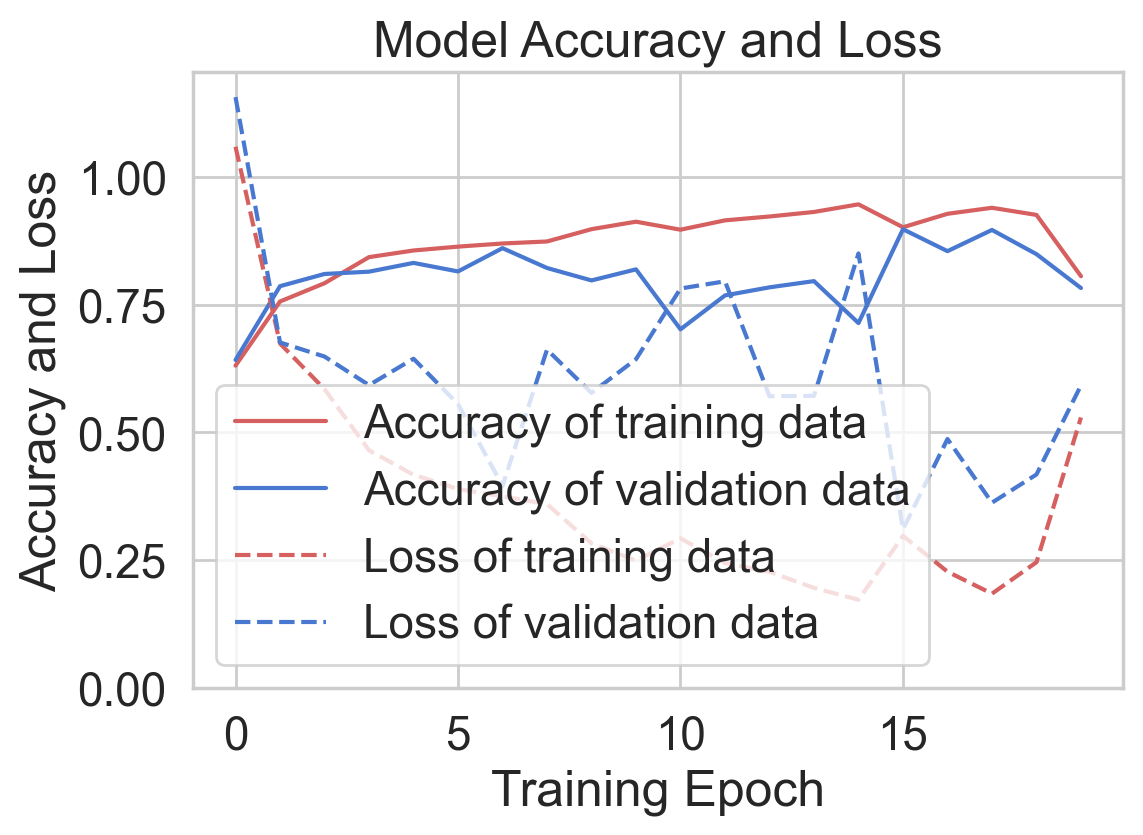

              precision    recall  f1-score   support

           0       0.65      0.48      0.55      2068
           1       0.97      0.98      0.97      6743
           2       0.95      0.96      0.96      1143
           3       0.94      0.90      0.92       957
           4       0.81      0.65      0.72      2566
           5       0.86      0.96      0.91      8684

    accuracy                           0.88     22161
   macro avg       0.86      0.82      0.84     22161
weighted avg       0.88      0.88      0.88     22161



In [92]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model.predict(X_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(np.argmax(y_train, axis = 1), max_y_pred_train))